## 기계학습을 이용한 감정 분석
- TDM 만들기
- TDM으로 별점 예측
    - 선형 모형의 일종인 엘라스틱넷 모형 이용
- 긍정/부정 예측
    - 로지스틱 회귀분석 모형 이용
    - 랜덤포레스트 분류기 이용

In [33]:
import numpy as np
import pandas as pd

In [2]:
cosmetic = pd.read_csv('../dataset/cosmetics_reviews_final.csv')

In [3]:
cosmetic.tail()

,product,brand_name,img_link,point,review
21217,마린 매직 클렌징 워터 리프레쉬 포뮬라,벨비죠,http://d9vmi5fxk1gsw.cloudfront.net/home/glowm...,4.67,클렌징워터인데 물묻혀서 비비면 클렌징폼이 돼서 좋다 거품이 많아서 좋ㄷ음
21218,마린 스파 바이탈 마스크 리프팅 리뉴얼,벨비죠,http://d9vmi5fxk1gsw.cloudfront.net/home/glowm...,3.52,가격도 싸고 색도 정말 예뻐서 좋은데 워터틴트라서 입술이 좀 건조해요
21219,마린 UV화이트닝 썬크림 SPF50+ PA+++,벨비죠,http://d9vmi5fxk1gsw.cloudfront.net/home/glowm...,5.00,촉촉하고 이거 베이스로 하면 화장 잘먹는거같아용 쉬머링효과도있고 너무너무 만족...
21220,멀티액션 콜라겐 BB 크림 SPF30 / PA++,벨비죠,http://d9vmi5fxk1gsw.cloudfront.net/home/glowm...,2.75,엥 이거 평이 다들 왜이렇게 안좋아요 제 인생템인데 어머니께서 좋은거 바르라고 ...
21221,자스민 그린티 토너,100% 퓨어,http://d9vmi5fxk1gsw.cloudfront.net/home/glowm...,3.20,중딩때 맨 날 들고다니면서 발랐던 거 나에겐 나름 추억의 애정템임 사진에...


### TDM 만들기

In [7]:
from konlpy.tag import Twitter
tag = Twitter()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
def kor_noun(text):
    words = []
    for w in tag.nouns(text):
        if len(w) > 1:
            words.append(w)
    return words

In [10]:
cv = CountVectorizer(tokenizer=kor_noun, max_features=1000)

In [11]:
tdm = cv.fit_transform(cosmetic['review'])

##### - 학습용 데이터와 테스트용 데이터 분할

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tdm, cosmetic['point'], test_size=.2, random_state =0)

### TDM으로 별점 예측
- 선형 모형의 일종인 엘라스틱넷 모형 이용

In [17]:
from sklearn.linear_model import ElasticNetCV

In [18]:
model = ElasticNetCV()

In [19]:
model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [20]:
y_pred = model.predict(X_test)

##### - 평균 오차 제곱

In [21]:
from sklearn.metrics import r2_score, mean_squared_error

In [22]:
mean_squared_error(y_test, y_pred)

0.5053197803671575

In [23]:
r2_score(y_test, y_pred)

0.12073943531234721

### 긍정/부정 예측

In [24]:
%matplotlib inline

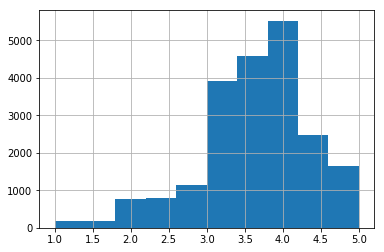

In [25]:
cosmetic['point'].hist()

In [12]:
high_low = cosmetic['point'] > 3.7

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tdm, high_low, test_size=.2, random_state =0)

### 로지스틱 회귀분석 모형 이용

In [14]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV()
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [15]:
y_pred = logreg.predict(X_test)

##### - 정확도 

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.6287396937573616

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.63      0.60      0.62      2111
       True       0.63      0.65      0.64      2134

avg / total       0.63      0.63      0.63      4245



##### - 단어별 긍/부정 확인

In [18]:
words = cv.get_feature_names()
sent_dict = sorted(zip(logreg.coef_[0], words))

In [23]:
len(sent_dict)

1000

In [21]:
# 회귀계수가 가장 작은 10단어
sent_dict[:20]   # 부정

[(-1.0317885978555437, '최악'),
 (-0.6854860808192937, '별로'),
 (-0.5858980001185569, '그닥'),
 (-0.5031729752101852, '쓰레기'),
 (-0.4923973974638098, '커버'),
 (-0.4779322366104383, '대충'),
 (-0.47300831554732553, '차라리'),
 (-0.47003853952640084, '사지'),
 (-0.4682470200517283, '그냥'),
 (-0.4152030914107307, '다행'),
 (-0.3833892342985934, '심해'),
 (-0.3766287431070354, '세일'),
 (-0.37495703857963225, '애매'),
 (-0.3724377289868339, '그때'),
 (-0.37015205256468753, '보지'),
 (-0.367392561153594, '수정'),
 (-0.3586819605731412, '별루'),
 (-0.35512782899395834, '다크닝'),
 (-0.3536090483994127, '뭉치'),
 (-0.3462576299485702, '글쎄')]

In [22]:
# 회귀계수가 가장 큰 10단어
sent_dict[-20:]  # 긍정

[(0.31513568268686193, '여름'),
 (0.3230147875953818, '안개'),
 (0.3297791935020135, '예정'),
 (0.33135386962920305, '향수'),
 (0.3361746454000259, '쫀쫀'),
 (0.3381478267709277, '무향'),
 (0.33965937086876385, '머릿결'),
 (0.3398269327651225, '메르'),
 (0.34527048770911256, '다만'),
 (0.3493656375683996, '인생'),
 (0.37234704439169053, '두피'),
 (0.378585763738899, '진정'),
 (0.38129168185030116, '일본'),
 (0.38821164393956087, '부들부들'),
 (0.4105669288415923, '잔향'),
 (0.42542645111329747, '지도'),
 (0.4325499121299252, '여성'),
 (0.43590948843753075, '대박'),
 (0.4363019788151628, '탱탱'),
 (0.4573019456578914, '강추')]

In [62]:
pos = []
neg = []
for row in sent_dict:
    if row[0] > 0:
        pos.append(row)
    elif row[0] < 0:
        neg.append(row)

In [63]:
len(pos), len(neg)

(543, 457)

In [65]:
neg[:10]

[(-1.0317885978555437, '최악'),
 (-0.6854860808192937, '별로'),
 (-0.5858980001185569, '그닥'),
 (-0.5031729752101852, '쓰레기'),
 (-0.4923973974638098, '커버'),
 (-0.4779322366104383, '대충'),
 (-0.47300831554732553, '차라리'),
 (-0.47003853952640084, '사지'),
 (-0.4682470200517283, '그냥'),
 (-0.4152030914107307, '다행')]

### 랜덤포레스트 분류기 이용

In [50]:
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [51]:
y_pred = ranfor.predict(X_test)

In [53]:
# 정확도
accuracy_score(y_test, y_pred)

0.6775029446407538

In [54]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.67      0.70      0.68      2111
       True       0.69      0.66      0.67      2134

avg / total       0.68      0.68      0.68      4245



In [56]:
importances = ranfor.feature_importances_

In [60]:
import matplotlib.pyplot as plt


std = np.std([tree.feature_importances_ for tree in ranfor.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

<Figure size 640x480 with 1 Axes>